In [1]:
import numpy as np
import joblib
from setfit import SetFitModel
from sklearn.metrics import f1_score, classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.base import BaseEstimator, ClassifierMixin
import pandas as pd
import json
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

#### Test Data -> annotated.json

In [2]:
def clean_text(text: str) -> str:
    """Lowercase, strip, replace - and / with spaces."""
    return str(text).lower().strip().replace("-", " ").replace("/", " ")

In [18]:
data = pd.read_csv(
    "/Users/jonas/Documents/Master_Vorlesungen/Semester_02/Practical Data Science/Final/PDS_Final/data/highest_active_jobs.csv",
)

X_test = data["position"].astype(str).apply(clean_text)
y_test_raw = data["seniority"].astype(str)

encoder = joblib.load("/Users/jonas/Documents/Master_Vorlesungen/Semester_02/Practical Data Science/Final/PDS_Final/models_done/encoder_seniority.joblib")
y_test = encoder.transform(y_test_raw.values.reshape(-1,1)).flatten()

#### Pipeline:

In [19]:
# Load BOW + Logistic Regression Model
bow_lr_model = joblib.load("/Users/jonas/Documents/Master_Vorlesungen/Semester_02/Practical Data Science/Final/PDS_Final/models_done/bow_seniority.joblib")

bow_lr_model

Pipeline(steps=[('bow',
                 CountVectorizer(max_df=0.9, min_df=3, ngram_range=(1, 2))),
                ('ros', RandomOverSampler(random_state=123)),
                ('clf',
                 LogisticRegression(C=1, max_iter=2000, solver='liblinear'))])

In [20]:
# Huggingface Model
model_hf = SetFitModel.from_pretrained(
    "/Users/jonas/Documents/Master_Vorlesungen/Semester_02/Practical Data Science/Final/PDS_Final/models_done/setfit_seniority",
    local_files_only=True
)

The tokenizer you are loading from '/Users/jonas/Documents/Master_Vorlesungen/Semester_02/Practical Data Science/Final/PDS_Final/models_done/setfit_seniority' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


In [21]:
enc_order = list(encoder.categories_[0])
hf_labels = list(model_hf.labels)

idx = [hf_labels.index(c) for c in enc_order]

aligned_label_order = [hf_labels[i] for i in idx]
print("HF labels (original):", hf_labels)
print("HF labels (reordered):", aligned_label_order)
print("Encoder order:", enc_order)

assert aligned_label_order == enc_order, "Alignment failed: reordered HF labels != encoder order"


HF labels (original): ['Director', 'Junior', 'Lead', 'Management', 'Professional', 'Senior']
HF labels (reordered): ['Junior', 'Professional', 'Senior', 'Lead', 'Management', 'Director']
Encoder order: ['Junior', 'Professional', 'Senior', 'Lead', 'Management', 'Director']


In [22]:
enc_classes = np.array(encoder.categories_[0], dtype=object)
enc_order = list(enc_classes)

def setfit_proba_aligned_to_encoder(model_hf, texts, enc_order):
    """
    SetFit predict_proba columns are in model_hf.labels order.
    Reorder them to match enc_order.
    """
    P = np.asarray(model_hf.predict_proba(texts))
    hf_labels = list(model_hf.labels)
    idx = [hf_labels.index(c) for c in enc_order]
    return P[:, idx]

def soft_vote_predict(model_bow, model_hf, X_texts, enc_classes, w_bow=0.2, w_hf=0.8):
    X_texts = list(X_texts)

    P_bow = model_bow.predict_proba(X_texts)
    P_hf  = setfit_proba_aligned_to_encoder(model_hf, X_texts, list(enc_classes))

    P_ens = (w_bow * P_bow + w_hf * P_hf) / (w_bow + w_hf)
    y_pred = enc_classes[np.argmax(P_ens, axis=1)]
    return y_pred, P_ens

X_test_texts = X_test.squeeze().astype(str).tolist()
y_test_str = y_test_raw.to_numpy()

y_pred_hf = np.array(model_hf.predict(X_test_texts), dtype=object)

print("HF Accuracy:", accuracy_score(y_test_str, y_pred_hf))
print("HF Macro F1:", f1_score(y_test_str, y_pred_hf, average="macro"))

y_pred_soft, P_ens = soft_vote_predict(
    bow_lr_model, model_hf, X_test_texts, enc_classes,
    w_bow=0.2, w_hf=0.8
)

print("\nSoftVote Accuracy:", accuracy_score(y_test_str, y_pred_soft))
print("SoftVote Macro F1:", f1_score(y_test_str, y_pred_soft, average="macro"))

print("\nSoftVote report:")
print(classification_report(
    y_test_str, y_pred_soft,
    labels=enc_order, target_names=enc_order,
    zero_division=0
))



HF Accuracy: 0.7866108786610879
HF Macro F1: 0.7059460440760983

SoftVote Accuracy: 0.7845188284518828
SoftVote Macro F1: 0.7022946769983726

SoftVote report:
              precision    recall  f1-score   support

      Junior       0.50      0.12      0.20         8
Professional       0.71      0.88      0.79       167
      Senior       0.97      0.71      0.82        41
        Lead       0.86      0.71      0.78        89
  Management       0.80      0.77      0.79       150
    Director       0.86      0.83      0.84        23

    accuracy                           0.78       478
   macro avg       0.78      0.67      0.70       478
weighted avg       0.79      0.78      0.78       478



<Figure size 12000x12000 with 0 Axes>

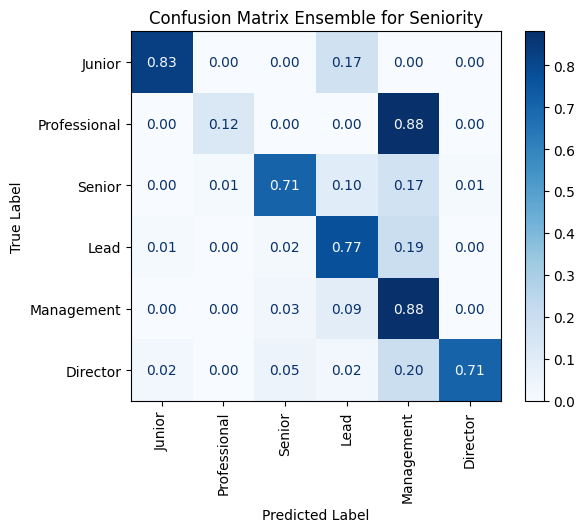

In [23]:
cm_norm = confusion_matrix(
    y_test_str,
    y_pred_soft,
    normalize="true"
)

plt.figure(figsize=(20, 20), dpi=600)

display = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=encoder.categories[0])
display.plot(cmap="Blues", xticks_rotation=90, values_format=".2f")

plt.title("Confusion Matrix Ensemble for Seniority")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig("plots/cm_ensemble_seniority.png", bbox_inches="tight")
plt.show()

Compare with Huggingface model alone

In [24]:
y_pred_hf = np.array(model_hf.predict(X_test_texts), dtype=object)

print("HF Accuracy:", accuracy_score(y_test_str, y_pred_hf))
print("HF Macro F1:", f1_score(y_test_str, y_pred_hf, average="macro"))
print(classification_report(
    y_test_str, y_pred_hf,
    labels=enc_order, target_names=enc_order,
    zero_division=0
))


HF Accuracy: 0.7866108786610879
HF Macro F1: 0.7059460440760983
              precision    recall  f1-score   support

      Junior       0.50      0.12      0.20         8
Professional       0.71      0.88      0.79       167
      Senior       1.00      0.71      0.83        41
        Lead       0.88      0.72      0.79        89
  Management       0.80      0.77      0.79       150
    Director       0.86      0.83      0.84        23

    accuracy                           0.79       478
   macro avg       0.79      0.67      0.71       478
weighted avg       0.80      0.79      0.78       478

